In [129]:
import matplotlib.pyplot as plt
import numpy as np
import urllib
from skimage import img_as_float
from skimage.transform import resize
from skimage.morphology import skeletonize
from skimage.morphology import binary_opening as opening
from skimage.morphology import binary_closing as closing
from skimage.morphology import binary_dilation as dilate
from skimage.morphology import binary_erosion as erode
from skimage.morphology import disk, label
from skimage.measure import regionprops_table
import pandas as pd
from scipy.spatial.distance import euclidean
import ipywidgets as widgets
from ipywidgets import interact

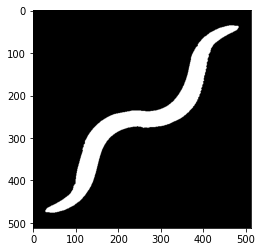

In [62]:
urllib.request.urlretrieve('http://clipart-library.com/img1/703813.jpg', 'worm.jpg')
im = plt.imread('worm.jpg', format='jpg')
im = np.pad((255 - im[:,:,0]), 40)
im = resize(img_as_float(im), (512,512)) > 0.5

plt.imshow(im, cmap='gray')

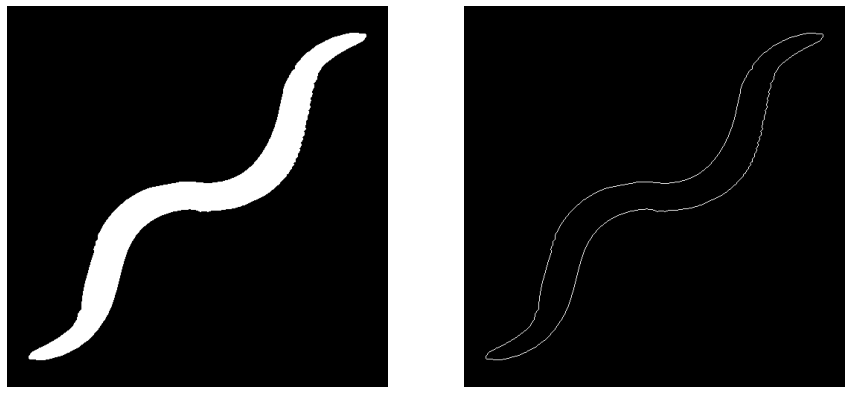

In [119]:

im_c = opening(im, disk(4))
im_co = closing(im_c, disk(30))
im_s = skeletonize(im_co)
im_b = im ^ erode(im, disk(1))

fig, ax = plt.subplots(figsize=(15,8), ncols=2)

ax[0].imshow(im, cmap='gray')
#ax[1].imshow(im_co, cmap='gray')
ax[1].imshow(im_b, cmap='gray')

for axi in ax:
  axi.axis('off')

In [82]:
idxs = np.argwhere(im_s) # Find all coordinates of skeleton
vs = np.diff(idxs, axis=0) # Calculate vectors to get direction of skeleton
vo = vs[:, ::-1] # Get vectors perpendicular to skeleten
vo[:,1] = -vo[:,1]



In [86]:
im_l = np.zeros((512,512)) > 0.5

xi = np.linspace(0, 511, 512)

x, y = np.meshgrid(xi, xi)

for i in range(1):

  if vo[i,0] == 0:
    im_l[x == idxs[i+1,0]] = True

  else:
    m = vo[i,1]/vo[i,0]
    b = idxs[i+1,1] - m*idxs[i+1,0]

    im_l[np.abs(y - (m*x + b)) < 0.5] = True

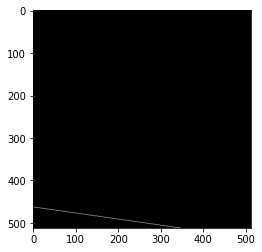

In [88]:
plt.imshow(im_l, cmap='gray')

In [175]:
def xsection(i=1):

  im_l = np.zeros((512,512)) > 0.5 # Create an empty array of 0s to image with cross-section lines
  xi = np.linspace(0, 511, 512) # Create grid of xy coordinates for Boolean operations
  y, x = np.meshgrid(xi, xi)

  if vo[i,0] == 0: # If the perpendicular vectors are vertical,
    im_l[x == idxs[i+1,0]] = True # Then draw vertical line at x location of skeleton

  else:
    m = vo[i,1]/vo[i,0] # Calculate slope of perpendicular line
    b = idxs[i+1,1] - m*idxs[i+1,0] # Calculate intercept of perpendicular line

    im_l[np.abs(y - (m*x + b)) < 0.5] = True # Draw perpendicular line in binary image

  # im_i = im_b & im_l
  # ends = np.argwhere(im_i)
  # dist = euclidean(ends[0,:], ends[1,:])

  im_i = dilate(im_b, disk(3)) & im_l # Find intersections of border with perpendicular line
  im_il = label(im_i) # Create labelled image of intersection points
  regions = regionprops_table(im_il, properties=('label','centroid')) # Find centroids of intersection points
  p1 = [regions['centroid-0'][0],regions['centroid-1'][0]]
  p2 = [regions['centroid-0'][-1],regions['centroid-1'][-1]]
  dist = euclidean(p1, p2) # Calculate distance between intersection points


  fig, ax = plt.subplots(figsize=(8,8))
  ax.axis('off')

  ax.imshow(1 - dilate(im_l, disk(3)), cmap='gray', origin='lower')
  ax.imshow(im, cmap='gray', alpha=0.5, origin='lower')
  ax.text(400, 400, np.round(dist,1), fontsize=20)


In [176]:
interact(xsection, i=widgets.IntSlider(value=0, min=0, max=615, step=1))

interactive(children=(IntSlider(value=0, description='i', max=615), Output()), _dom_classes=('widget-interact'…

<function __main__.xsection>